In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings('ignore')

## Data loading

In [2]:
data = pd.read_csv("hcv_data.csv", sep=',')
data.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


# Preprocessing 

In [3]:
data.drop(data.columns[data.columns.str.contains('unnamed', case = False)], axis = 1, inplace = True)

In [4]:
data['Category'].unique()

array(['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis',
       '2=Fibrosis', '3=Cirrhosis'], dtype=object)

In [5]:
sex = {'m': 1,'f': 0}
category = {
    '0=Blood Donor': 0, '0s=suspect Blood Donor': 0, 
    '1=Hepatitis': 1, '2=Fibrosis': 1, '3=Cirrhosis': 1
}
data.Sex = [sex[item] for item in data.Sex]
data.Category = [category[item] for item in data.Category]
data.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,1,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,1,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,1,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,1,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [6]:
data.describe()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,0.121951,47.408130,0.613008,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,0.327496,10.055105,0.487458,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,0.000000,19.000000,0.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,0.000000,39.000000,0.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,0.000000,47.000000,1.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,0.000000,54.000000,1.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,1.000000,77.000000,1.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [7]:
data.shape

(615, 13)

In [8]:
data.dtypes

Category      int64
Age           int64
Sex           int64
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
dtype: object

### Checking missing values 

In [9]:
names = data.columns[data.isna().any()].tolist()
names 

['ALB', 'ALP', 'ALT', 'CHOL', 'PROT']

In [10]:
data.isna().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

In [11]:
for name in names:
    data[name].fillna((data[name].mean()), inplace=True)


In [12]:
data.isna().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

### The outliers

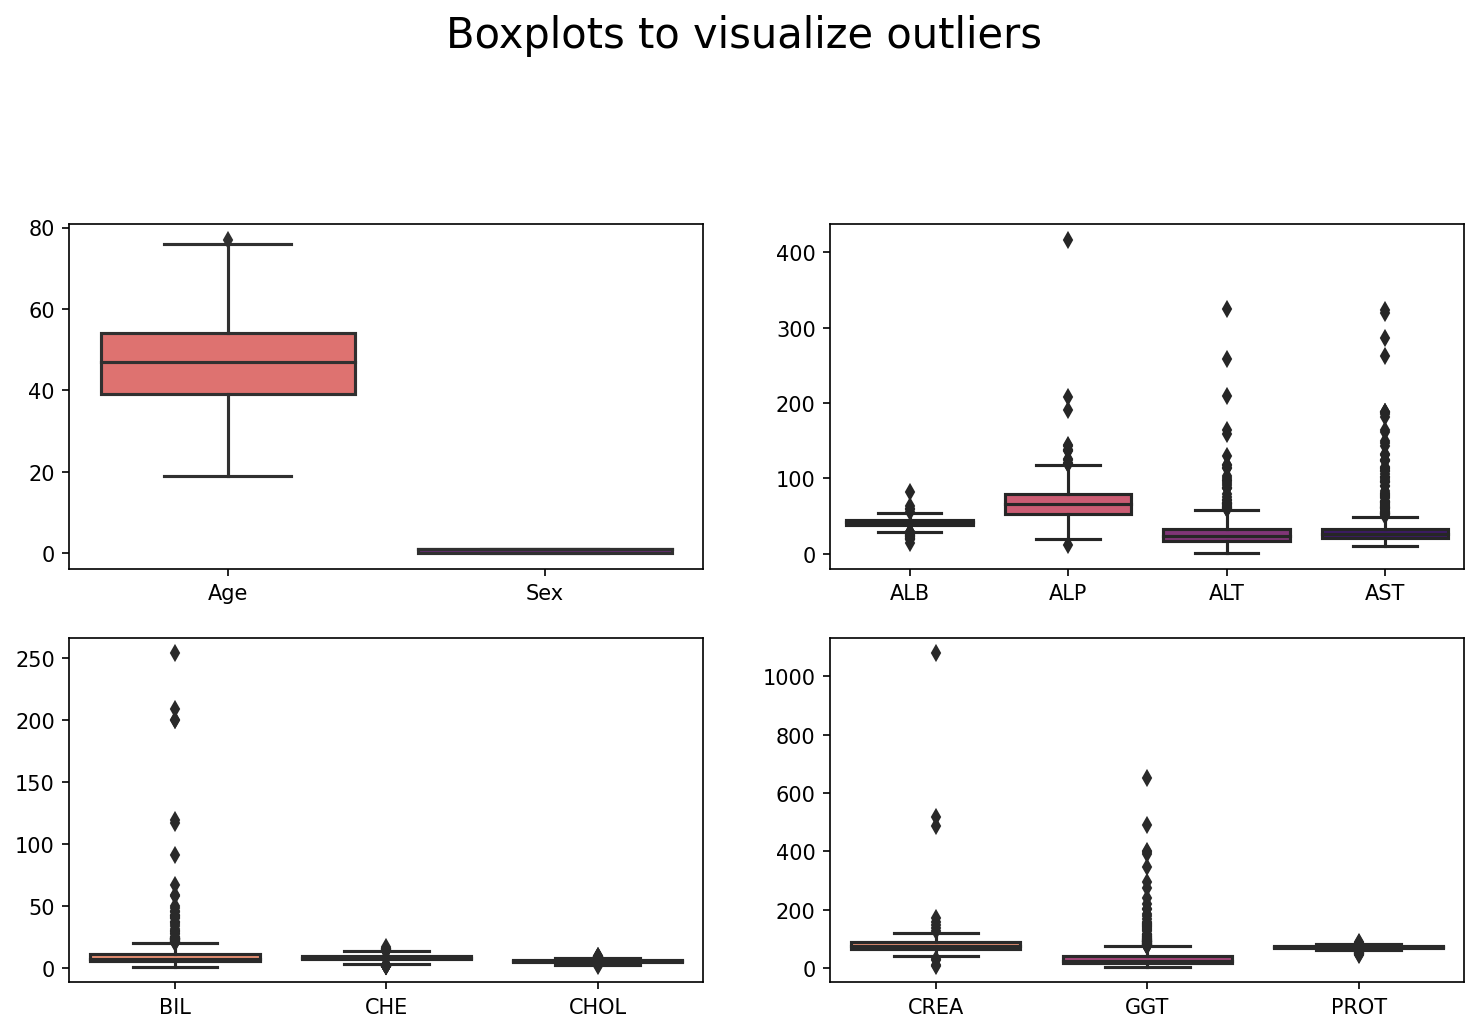

In [13]:
plt.figure(dpi=150, figsize=(12,14))

plt.subplot(4, 2, 1)
sns.boxplot(data=data[['Age', 'Sex']], palette="magma_r")

plt.subplot(4, 2, 2)
sns.boxplot(data=data[['ALB', 'ALP', 'ALT', 'AST']], palette="magma_r")

plt.subplot(4, 2, 3)
sns.boxplot(data=data[['BIL', 'CHE', 'CHOL']], palette="magma_r")

plt.subplot(4, 2, 4)
sns.boxplot(data=data[['CREA', 'GGT', 'PROT']], palette="magma_r")

plt.suptitle("Boxplots to visualize outliers", fontsize=20)

plt.savefig('saved_figs/outliers.svg', format='svg')

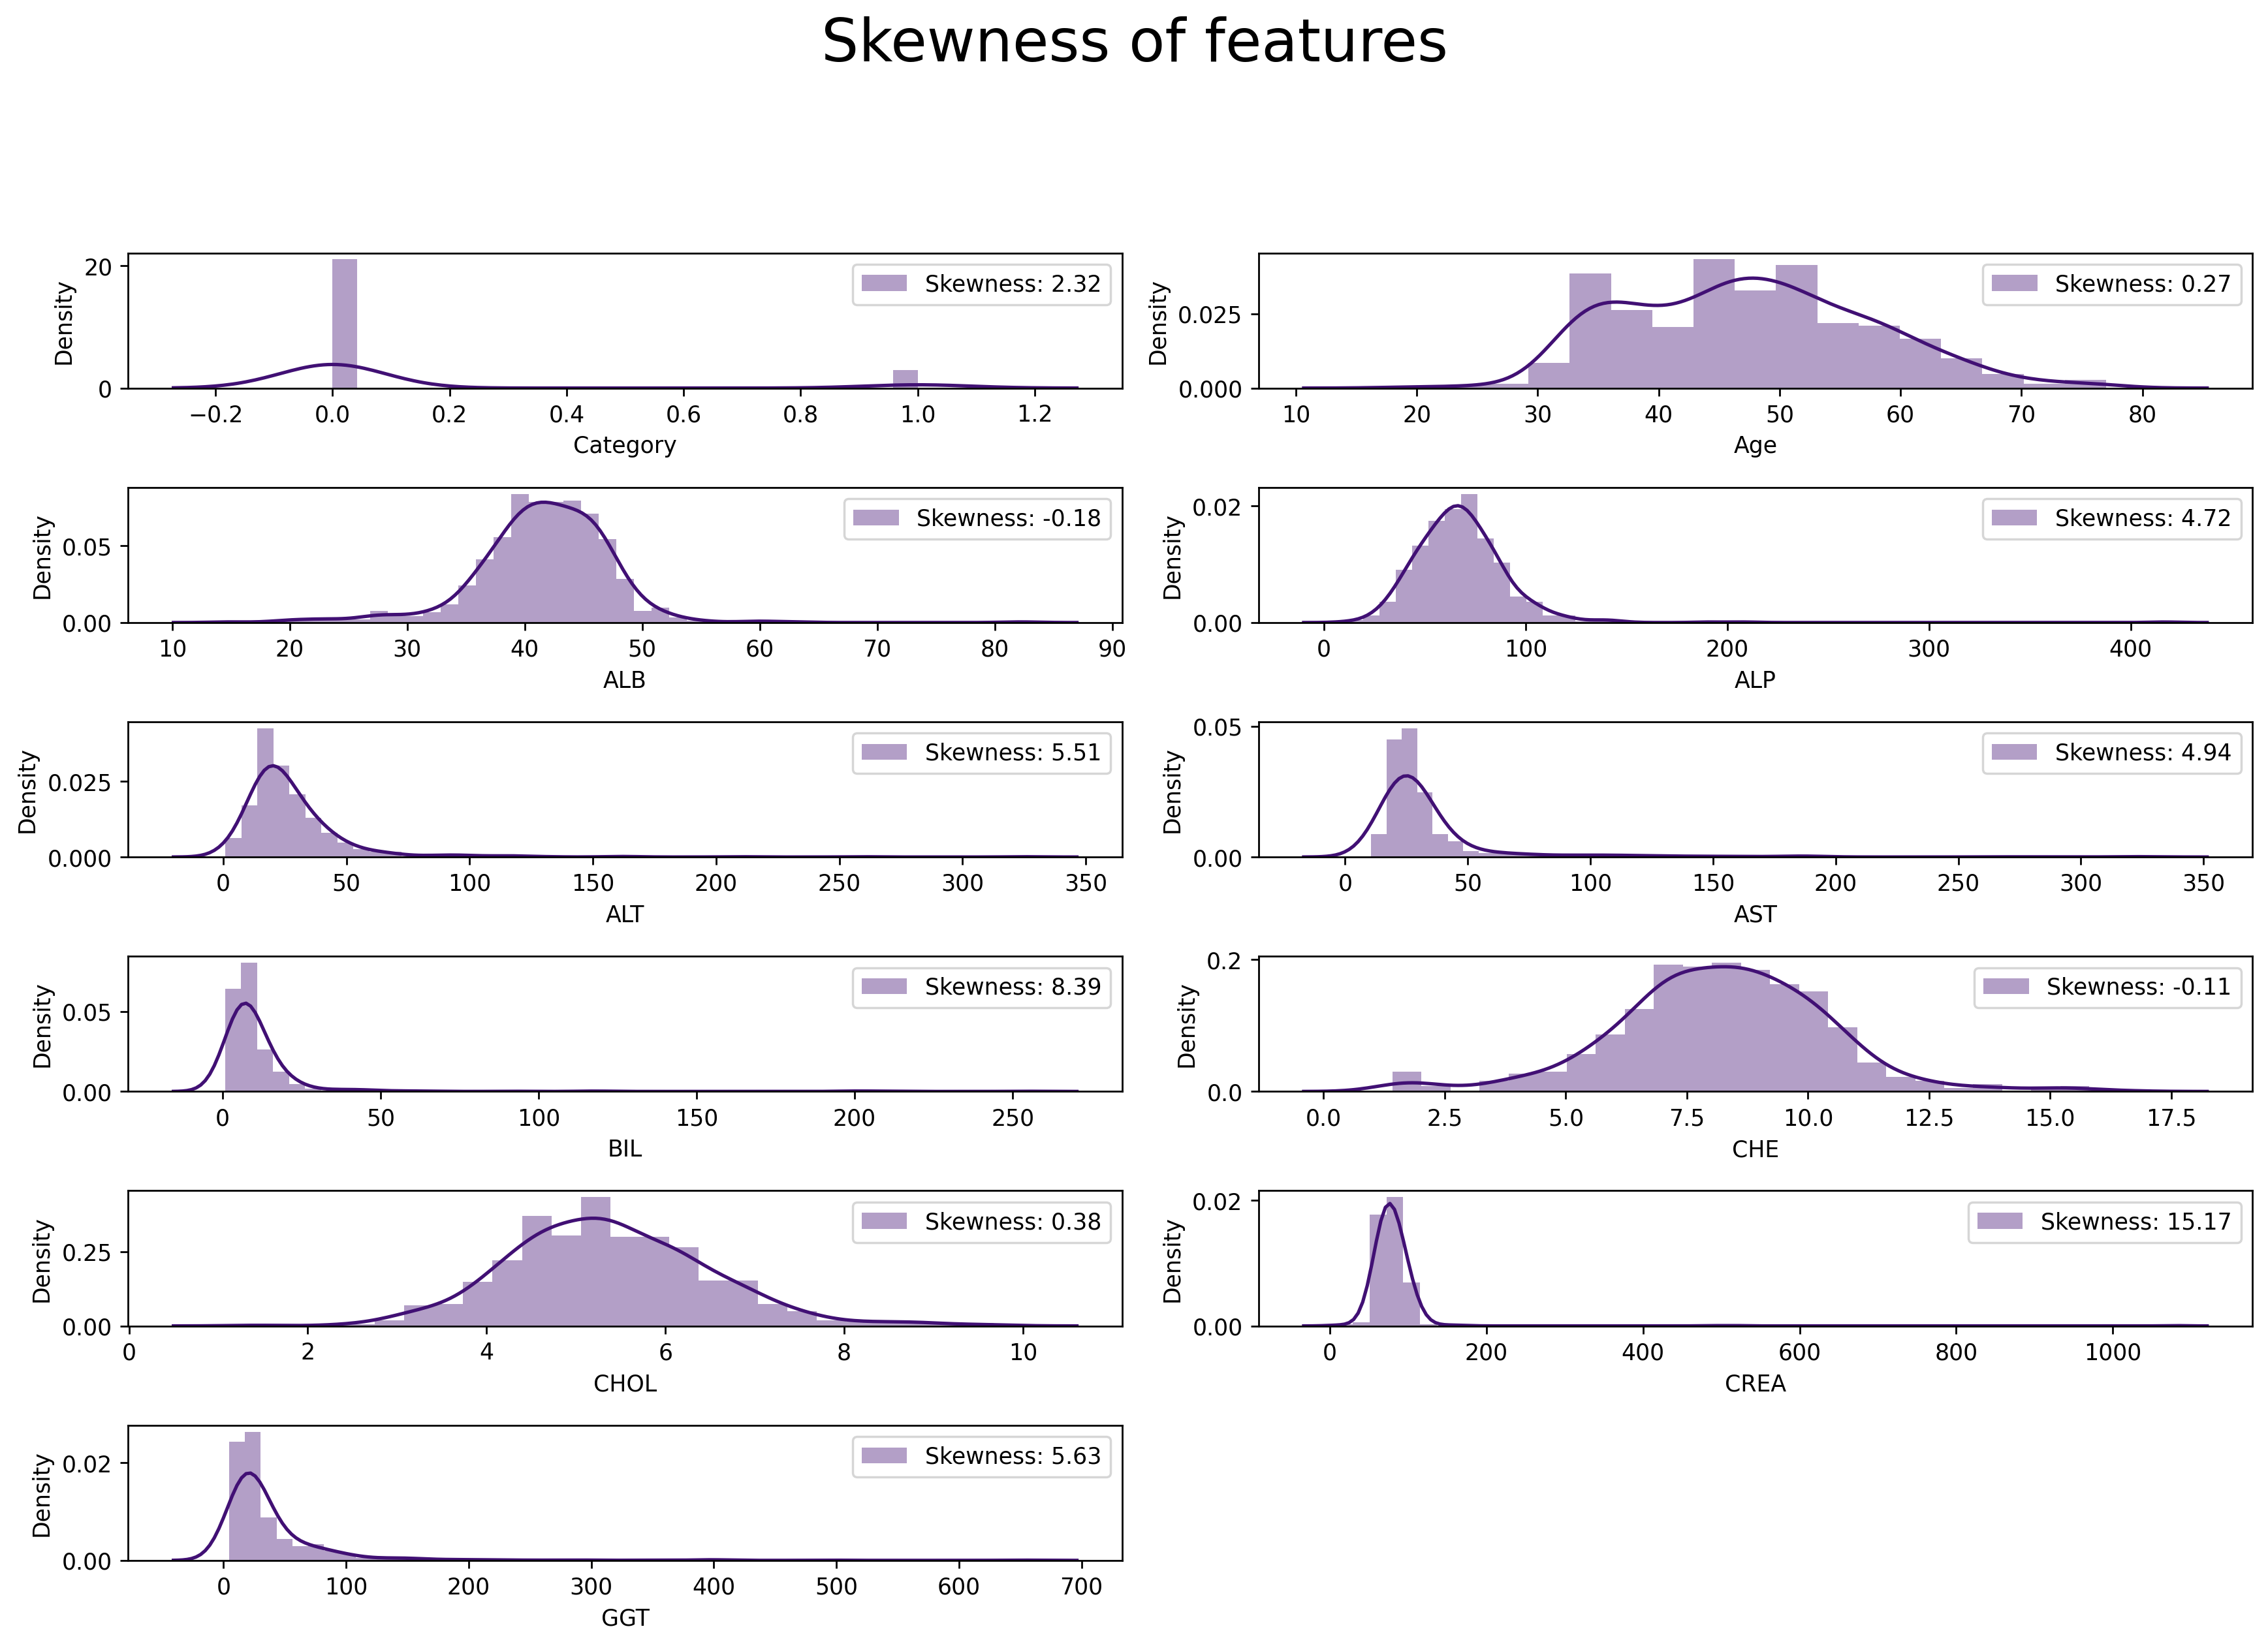

In [14]:
skewness = [data[feature].skew() for feature in data.columns[0:12].drop('Sex')]

plt.figure(figsize=(14,16), dpi=250)
for i, skew, feature in zip(range(0,11), skewness, data.columns[0:12].drop('Sex')):
    plt.subplot(11, 2, i+1)
    sns.distplot(data[feature], color="#411074", label="Skewness: %.2f"%(skew))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.suptitle("Skewness of features", fontsize=26, y=1.05)

plt.savefig('saved_figs/skewness.svg', format='png')

In [15]:
# Q1 
q1 = data.quantile(0.25)
# Q3
q3 = data.quantile(0.75)
# IQR
IQR = q3 - q1
# Outlier range
upper = q3 + IQR * 1.5
lower = q1 - IQR * 1.5
upper_dict = dict(upper)
lower_dict = dict(lower)

In [16]:
for i, v in data.items():
    v_col = v[( v<= lower_dict[i]) | (v >= upper_dict[i])]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
    print("Column {} outliers = {} => {}%".format(i, len(v_col), round((perc),3)))

Column Category outliers = 615 => 100.0%
Column Age outliers = 1 => 0.163%
Column Sex outliers = 0 => 0.0%
Column ALB outliers = 27 => 4.39%
Column ALP outliers = 14 => 2.276%
Column ALT outliers = 36 => 5.854%
Column AST outliers = 64 => 10.407%
Column BIL outliers = 47 => 7.642%
Column CHE outliers = 24 => 3.902%
Column CHOL outliers = 12 => 1.951%
Column CREA outliers = 12 => 1.951%
Column GGT outliers = 65 => 10.569%
Column PROT outliers = 20 => 3.252%


In [17]:
#Using log transformation
scaler = RobustScaler()
columns_to_scale = ["AST", "GGT", "BIL", 'ALT']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
print("The first 5 rows of transformed data are")
data.head()

The first 5 rows of transformed data are


,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,1,38.5,52.5,-0.918919,-0.336283,0.033898,6.93,3.23,106.0,-0.457143,69.0
1,0,32,1,38.5,70.3,-0.300300,-0.106195,-0.576271,11.17,4.80,74.0,-0.314286,76.5
2,0,32,1,46.9,74.7,0.792793,2.362832,-0.203390,8.84,5.20,86.0,0.404082,79.3
3,0,32,1,43.2,52.0,0.456456,-0.292035,1.966102,7.33,4.74,80.0,0.428571,75.7
4,0,32,1,39.2,74.1,0.576577,-0.097345,0.389831,9.15,4.32,76.0,0.269388,68.7


### Plotting imbalanced data 

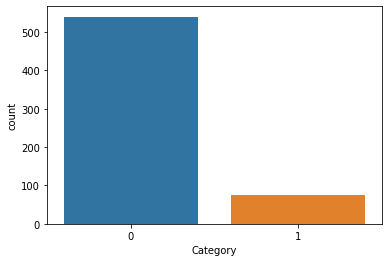

In [18]:
sns.countplot(data['Category'], label='count').set(title='')
data['Category'].value_counts()
plt.savefig('saved_figs/class_count.svg', format='svg')

## Data visualisation 

1    377
0    238
Name: Sex, dtype: int64

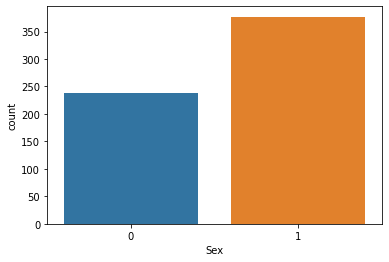

In [19]:
sns.countplot(data['Sex'], label='count')
data['Sex'].value_counts()

Text(0, 0.5, 'Density')

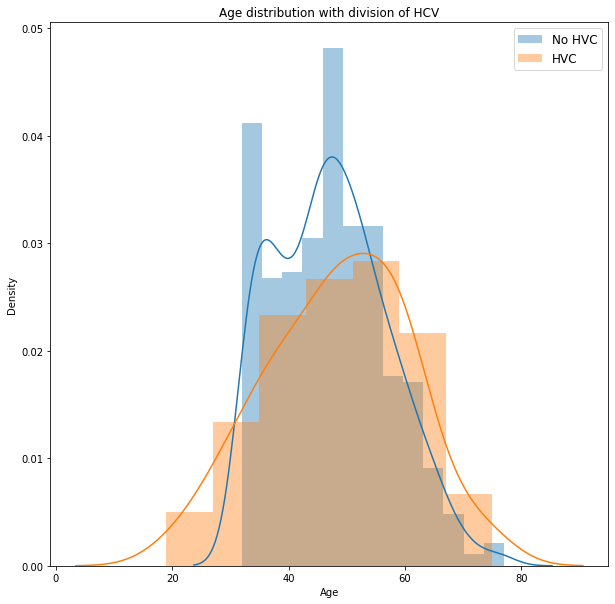

In [20]:
categories = ['No HVC', 'HVC']

plt.figure(figsize=(10, 10))
for i, name in enumerate(categories):
    df = data[data.Category == i]
    sns.distplot(df['Age'], kde=True, label=name)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Age distribution with division of HCV')
plt.xlabel('Age')
plt.ylabel('Density')

### Correlation and heatmap

In [21]:
data.corr()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Category,1.000000,0.037781,0.071663,-0.179859,-0.061356,0.088726,0.621724,0.398451,-0.230785,-0.265474,0.136772,0.437680,0.083956
Age,0.037781,1.000000,-0.024544,-0.197005,0.168473,-0.006017,0.088666,0.032492,-0.075093,0.123978,-0.022296,0.153087,-0.153665
Sex,0.071663,-0.024544,1.000000,0.146065,-0.019547,0.161785,0.130891,0.111177,0.169111,-0.029886,0.159589,0.133276,0.051250
ALB,-0.179859,-0.197005,0.146065,1.000000,-0.138858,0.001606,-0.193397,-0.221650,0.375848,0.204803,-0.001573,-0.155555,0.550033
ALP,-0.061356,0.168473,-0.019547,-0.138858,1.000000,0.172461,0.062202,0.048600,0.032971,0.121914,0.149554,0.442262,-0.053633
ALT,0.088726,-0.006017,0.161785,0.001606,0.172461,1.000000,0.273325,-0.038468,0.146953,0.068023,-0.043025,0.248086,0.094373
AST,0.621724,0.088666,0.130891,-0.193397,0.062202,0.273325,1.000000,0.312231,-0.208536,-0.207507,-0.021387,0.491263,0.039888
BIL,0.398451,0.032492,0.111177,-0.221650,0.048600,-0.038468,0.312231,1.000000,-0.333172,-0.156261,0.031224,0.217024,-0.041309
CHE,-0.230785,-0.075093,0.169111,0.375848,0.032971,0.146953,-0.208536,-0.333172,1.000000,0.420163,-0.011157,-0.110345,0.293184
CHOL,-0.265474,0.123978,-0.029886,0.204803,0.121914,0.068023,-0.207507,-0.156261,0.420163,1.000000,-0.047667,-0.006828,0.206546


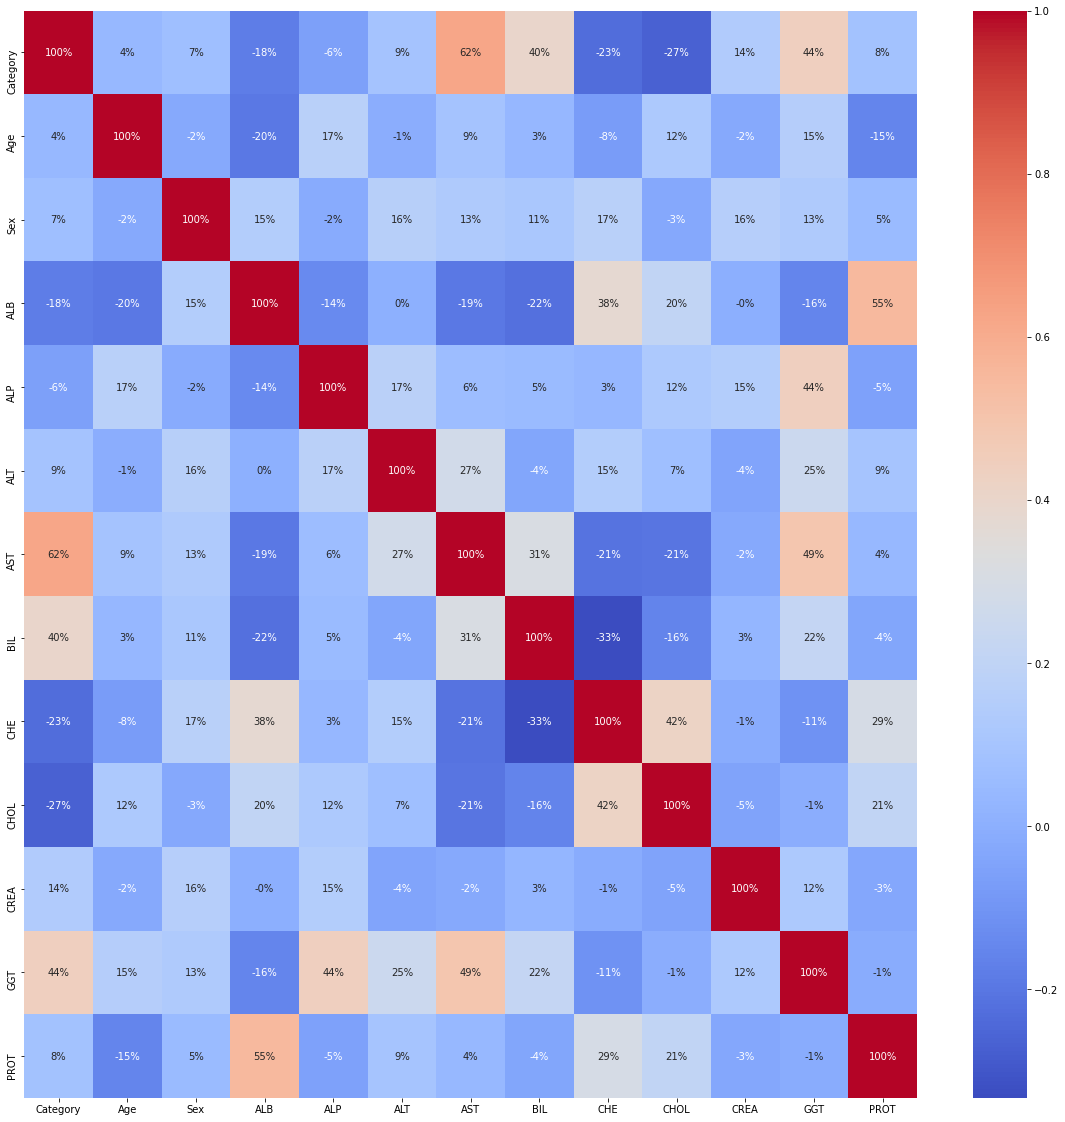

In [22]:
plt.figure(figsize=(20,20))  
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.0%')
plt.savefig('saved_figs/heatmap.svg', format='svg')

> Column Category outliers = 615 => 100.0%
> Column Age outliers = 1 => 0.163%
> Column Sex outliers = 0 => 0.0%
> Column ALB outliers = 27 => 4.39%
> Column ALP outliers = 14 => 2.276%
> Column ALT outliers = 36 => 5.854%
> Column AST outliers = 64 => 10.407%
> Column BIL outliers = 47 => 7.642%
> Column CHE outliers = 24 => 3.902%
> Column CHOL outliers = 12 => 1.951%
> Column CREA outliers = 12 => 1.951%
> Column GGT outliers = 65 => 10.569%
> Column PROT outliers = 20 => 3.252%

In [23]:
X = data.drop('Category', axis=1).copy()
y = data['Category'].copy()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size = 0.30, random_state = 0, stratify = y)

### Oversampling the data with ADASYN algorithm

In [25]:
y_values = y_train.values
X_train, y_train = ADASYN(random_state=0).fit_resample(X_train, y_train)

In [26]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 378, 1: 376}

# Training 

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=0)) 
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=0))
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier()) 

tree = DecisionTreeClassifier(random_state=0)
tree = tree.fit(X_train, y_train)

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

ada = AdaBoostClassifier(random_state=0)
ada.fit(X_train, y_train)

param_C = np.arange(0.01, 1.0, 0.01)
param_gamma = np.arange(0.01, 1.0, 0.01)
param_pca = np.arange(2, 25)
param_knn = np.arange(2, 25)

param_grid_lr = [{'logisticregression__C': param_C,'pca__n_components': param_pca}]

param_grid_svc = [{'svc__C': param_C, 
               'svc__kernel': ['linear']},
              {'svc__C': param_gamma, 
               'svc__gamma': param_C, 
               'svc__kernel': ['rbf']}]

param_grid_knn = [{'kneighborsclassifier__n_neighbors': param_knn}]


path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

random_grid_tree = {'ccp_alpha': ccp_alphas,
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.arange(1, 30)]}

random_grid_forest = {'n_estimators': [x for x in np.arange(10, 300, 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.arange(1, 20)],
               'min_samples_split': np.arange(1, 20),
               'min_samples_leaf': np.arange(1, 5),
               'bootstrap': [True, False]}

random_grid_ada = {'n_estimators': [x for x in np.arange(10, 400, 5)],
                  'learning_rate': np.arange(0.1, 4.1, 0.1)}

classifiers_1 = [pipe_lr, pipe_svc, pipe_knn]
parameters_1 = [param_grid_lr, param_grid_svc, param_grid_knn]
names_1 = ['Logistic Regression', 'SVC', 'KNN']

classifiers_2 = [tree, forest, ada]
parameters_2 = [random_grid_tree, random_grid_forest, random_grid_ada]
names_2 = ['Decision Tree', 'Random Forest', 'AdaBoost']

for clf, param, name in zip(classifiers_1, parameters_1, names_1):
    clf.fit(X_train, y_train)
    gs = GridSearchCV(estimator=clf, 
                      param_grid=param, 
                      scoring='accuracy', 
                      cv=5,
                      n_jobs=-1)
    
    
    gs = gs.fit(X_train, y_train)
    print(name)
    print(round(gs.best_score_, 2))
    print(gs.best_params_)
    y_pred = gs.predict(X_test)
    print("The test accuracy score of {} after hyper-parameter tuning is ".format(name), round(accuracy_score(y_test, y_pred),2))
    print("")

for clf, param, name in zip(classifiers_2, parameters_2, names_2):
    rs = RandomizedSearchCV(estimator=clf, 
                                   param_distributions=param, 
                                   n_iter=100, cv=5, verbose=2, 
                                   random_state=0, n_jobs=-1)

    # # Fit the random search model
    print(name)
    rs.fit(X_train, y_train)
    print(rs.best_params_)
    print('accuracy:', round(rs.best_score_, 2))
    y_pred = rs.predict(X_test)
    print("The test accuracy score of {} after hyper-parameter tuning is".format(name), round(accuracy_score(y_test, y_pred),2))
    print("")

    

Logistic Regression
0.95
{'logisticregression__C': 0.67, 'pca__n_components': 11}
The test accuracy score of Logistic Regression after hyper-parameter tuning is  0.95

SVC
0.99
{'svc__C': 0.8, 'svc__gamma': 0.08, 'svc__kernel': 'rbf'}
The test accuracy score of SVC after hyper-parameter tuning is  0.97

KNN
0.96
{'kneighborsclassifier__n_neighbors': 3}
The test accuracy score of KNN after hyper-parameter tuning is  0.92

Decision Tree
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'max_features': 'sqrt', 'max_depth': 28, 'ccp_alpha': 0.0}
accuracy: 0.96
The test accuracy score of Decision Tree after hyper-parameter tuning is 0.94

Random Forest
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 175, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
accuracy: 0.99
The test accuracy score of Random Forest after hyper-parameter tuning is 0.96

AdaBoost
Fitting 5 folds for each of 100 ca

In [30]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=11), LogisticRegression(C=0.67, random_state=0))
pipe_svc = make_pipeline(StandardScaler(), SVC(C=0.8, gamma=0.08, kernel='rbf', random_state=0, probability=True))
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))

pipe_tree = make_pipeline(StandardScaler(), DecisionTreeClassifier(ccp_alpha=0, random_state=0, max_features = 'sqrt',
                                                                     max_depth=28, criterion = 'gini'))

pipe_forest = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=175, random_state=0,
                                                                      min_samples_leaf=1, max_features = 'sqrt',
                                                                     max_depth=10, bootstrap=False,
                                                                    min_samples_split=6))

pipe_ada = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=385, random_state=0, learning_rate = 1.7))
classifiers = [pipe_lr, pipe_svc, pipe_knn, pipe_tree, pipe_forest, pipe_ada]
names = names_1
names += names_2

In [31]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5, n_jobs=-1)
    print(name)
    print('The training k-fold accuracy score: %.3f +/- %.3f' % ((np.mean(scores)), np.std(scores)))

Logistic Regression
The training k-fold accuracy score: 0.955 +/- 0.018
SVC
The training k-fold accuracy score: 0.988 +/- 0.005
KNN
The training k-fold accuracy score: 0.959 +/- 0.016
Decision Tree
The training k-fold accuracy score: 0.964 +/- 0.018
Random Forest
The training k-fold accuracy score: 0.993 +/- 0.006
AdaBoost
The training k-fold accuracy score: 0.991 +/- 0.010


# Prediction  

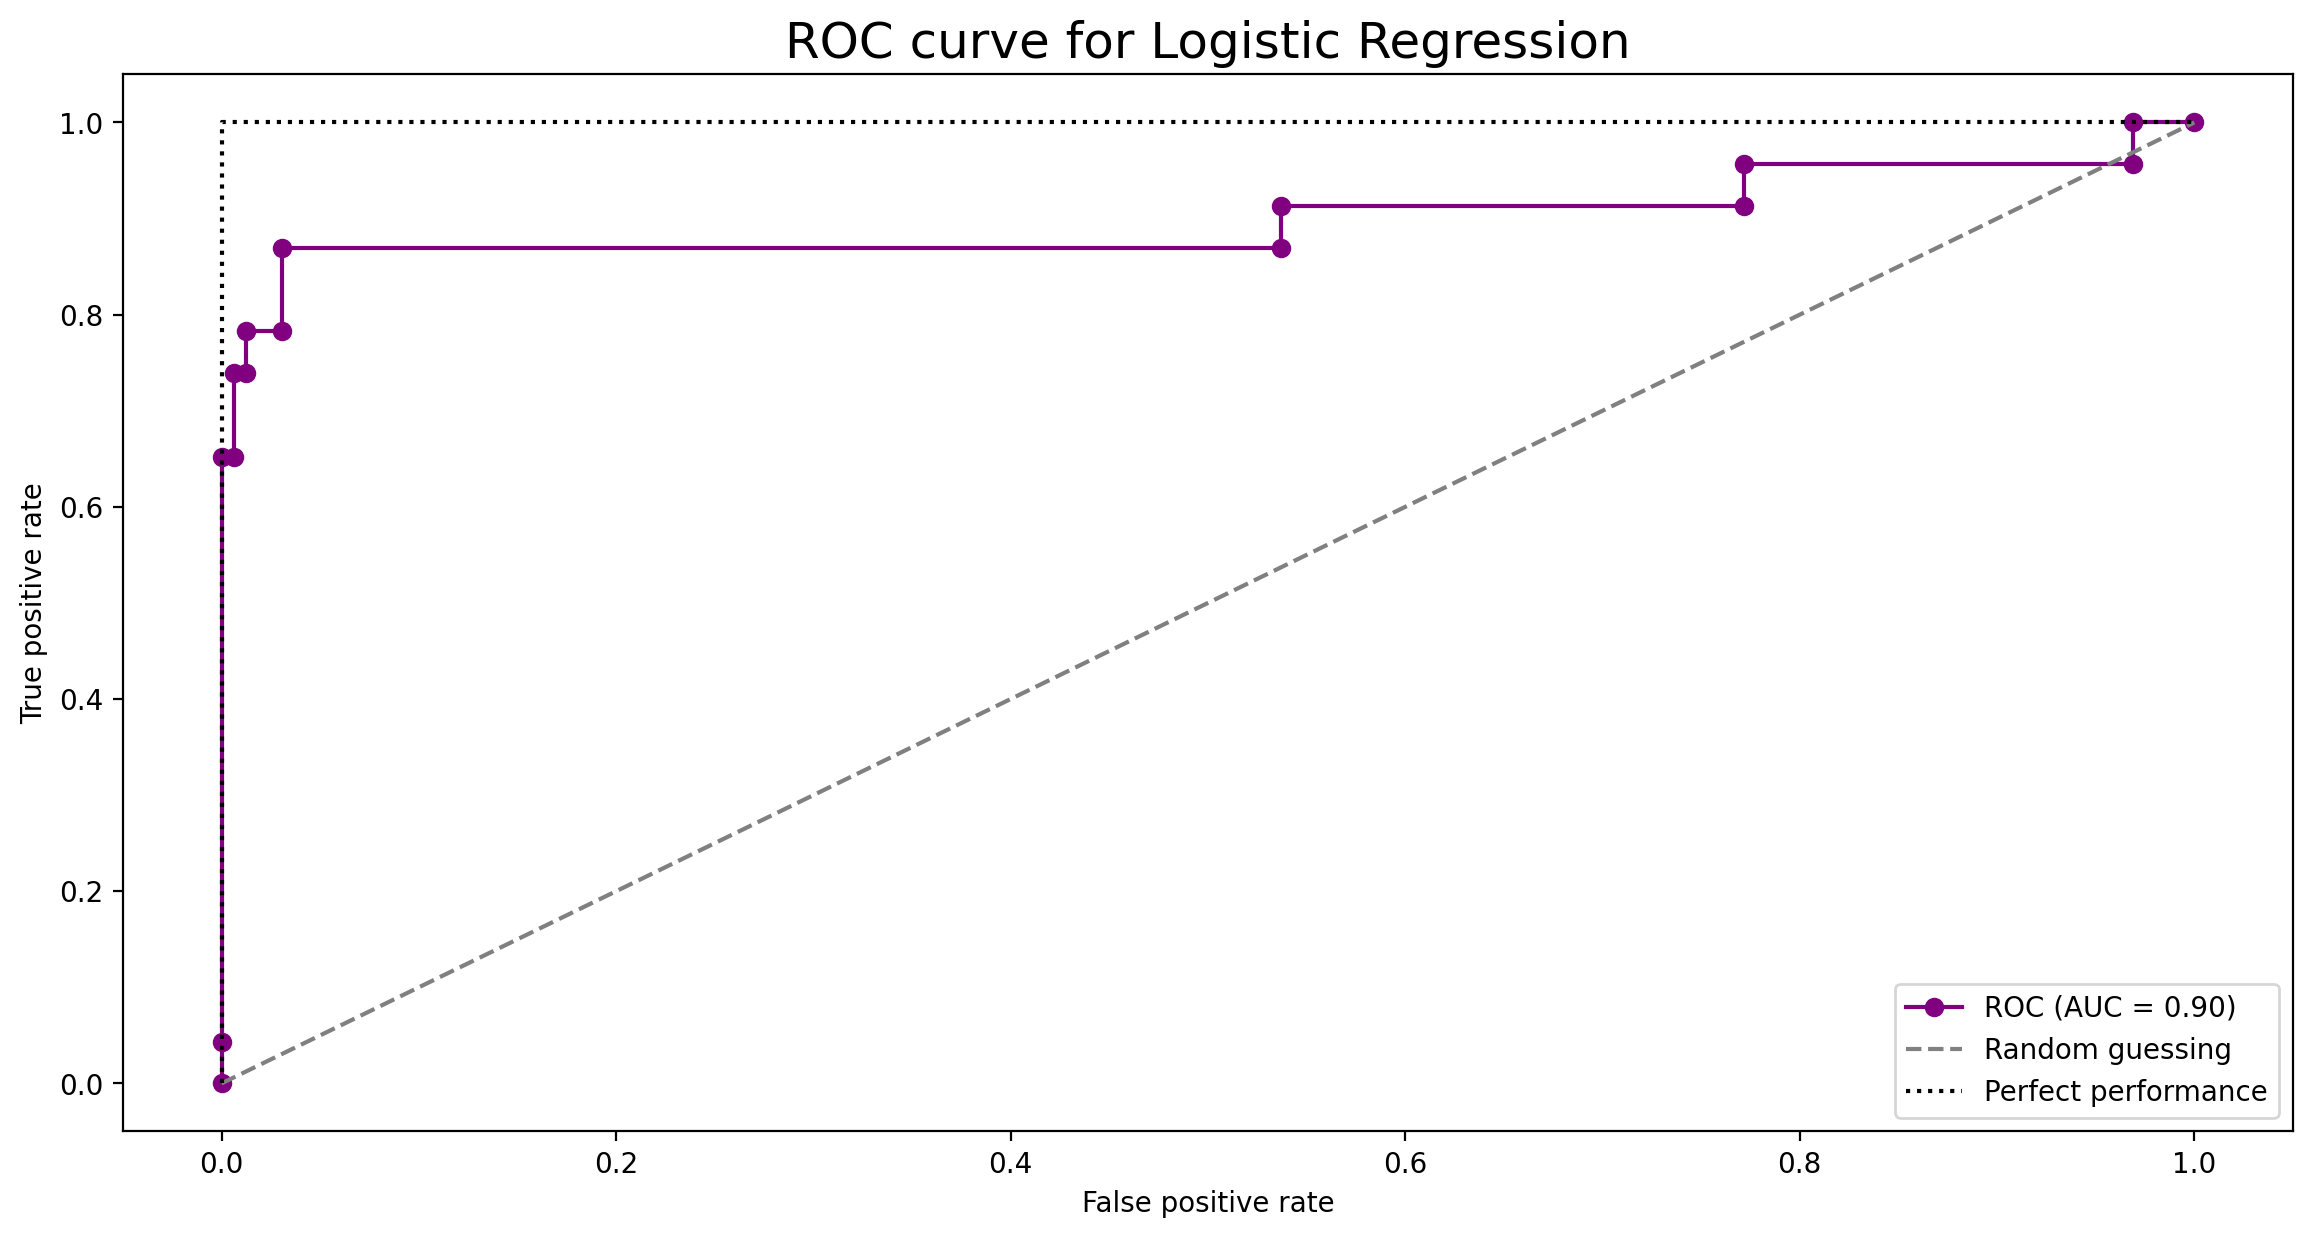

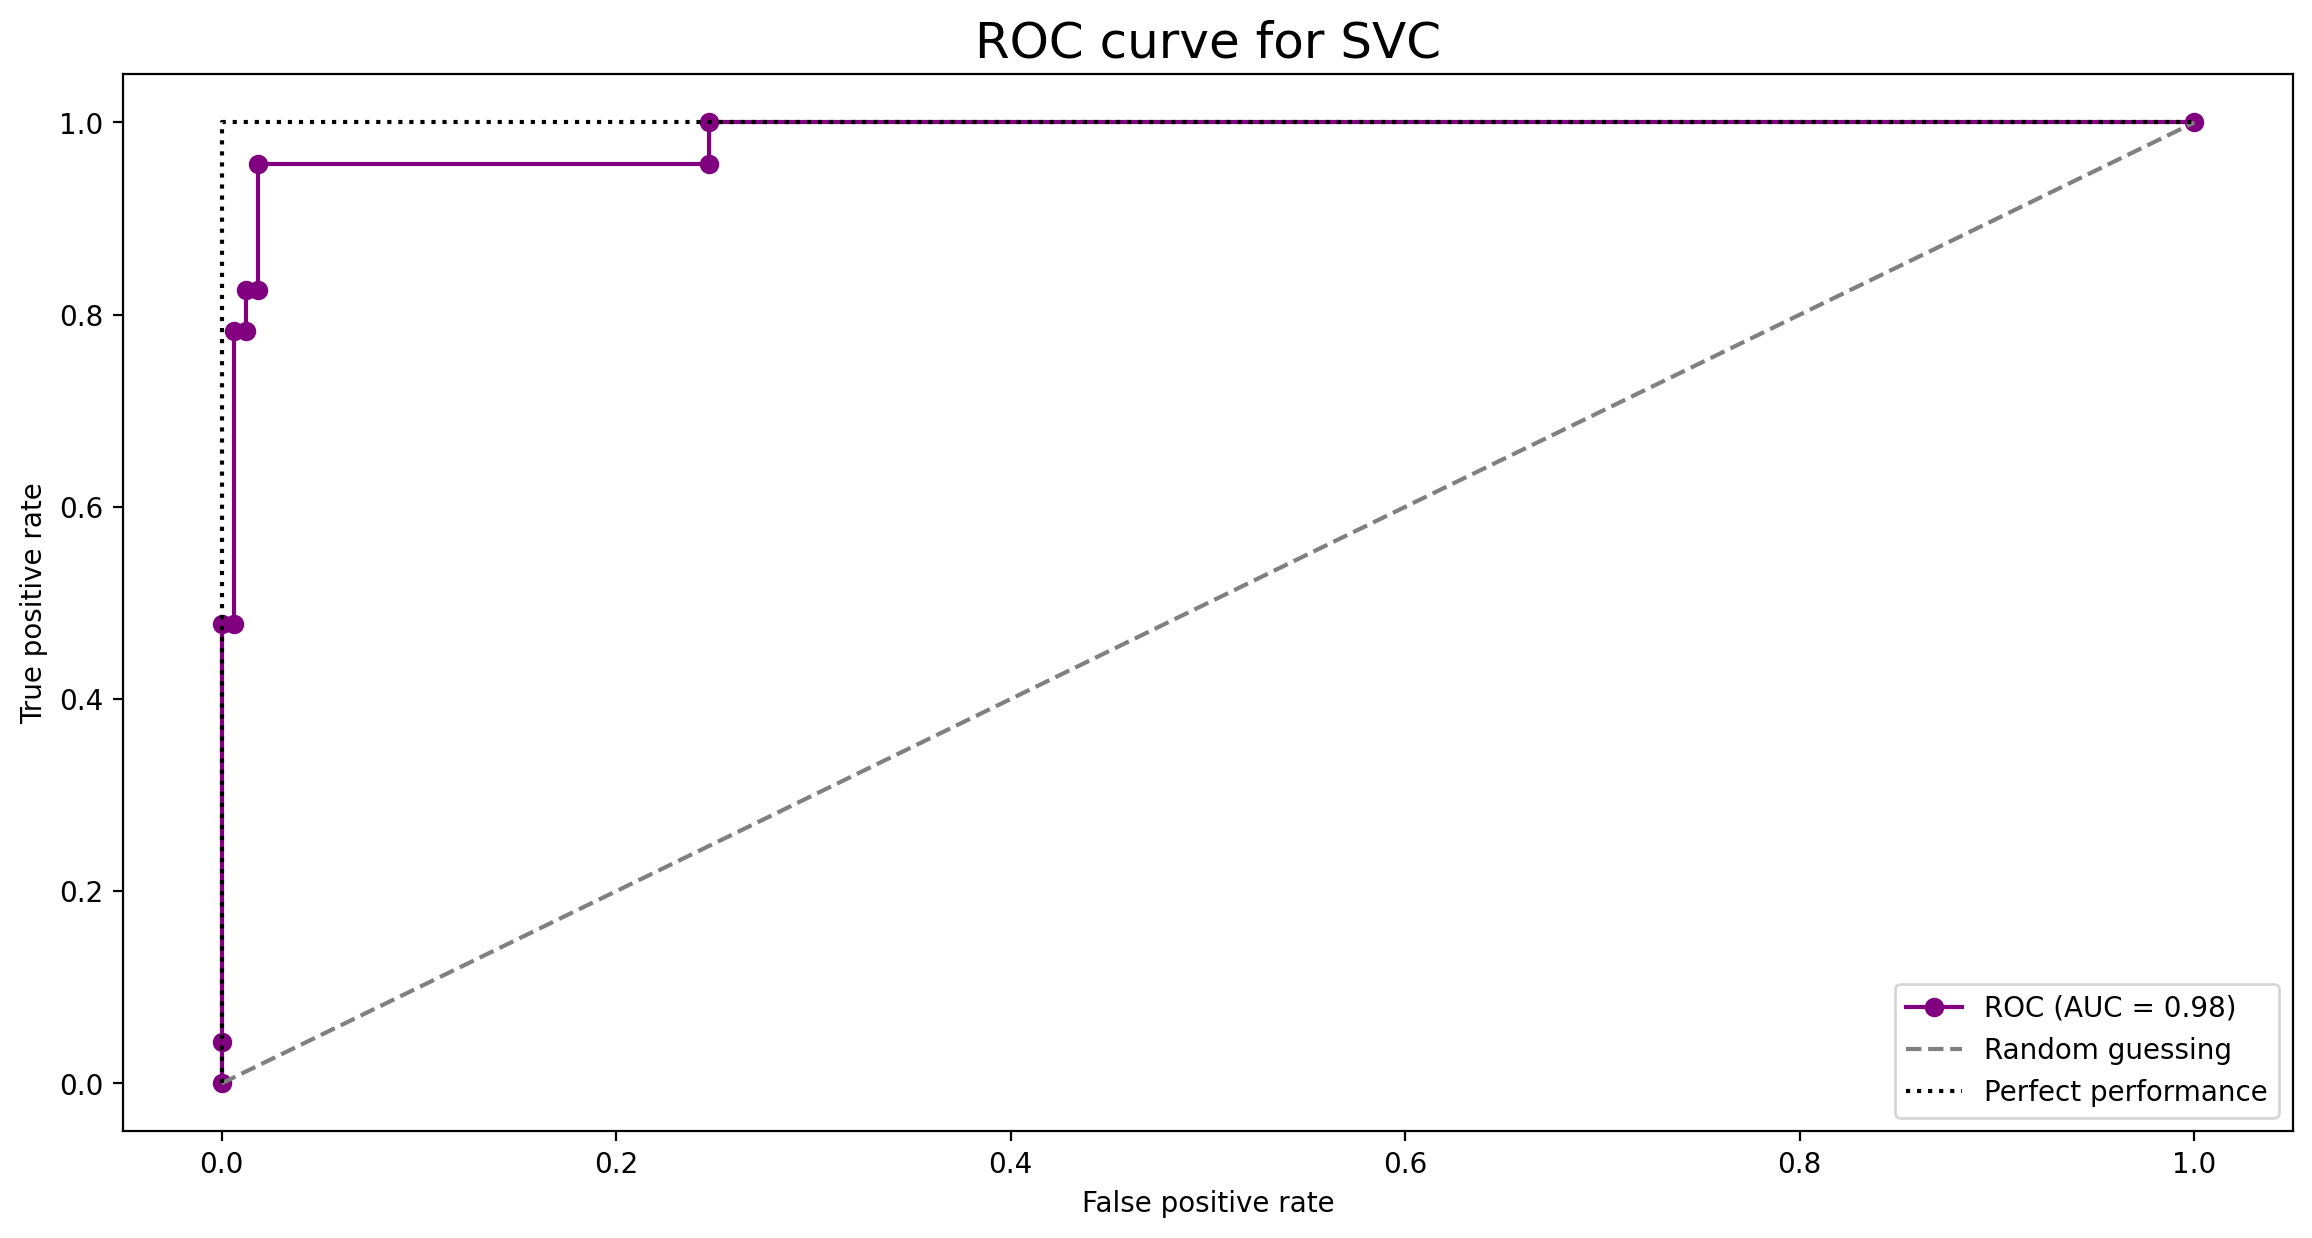

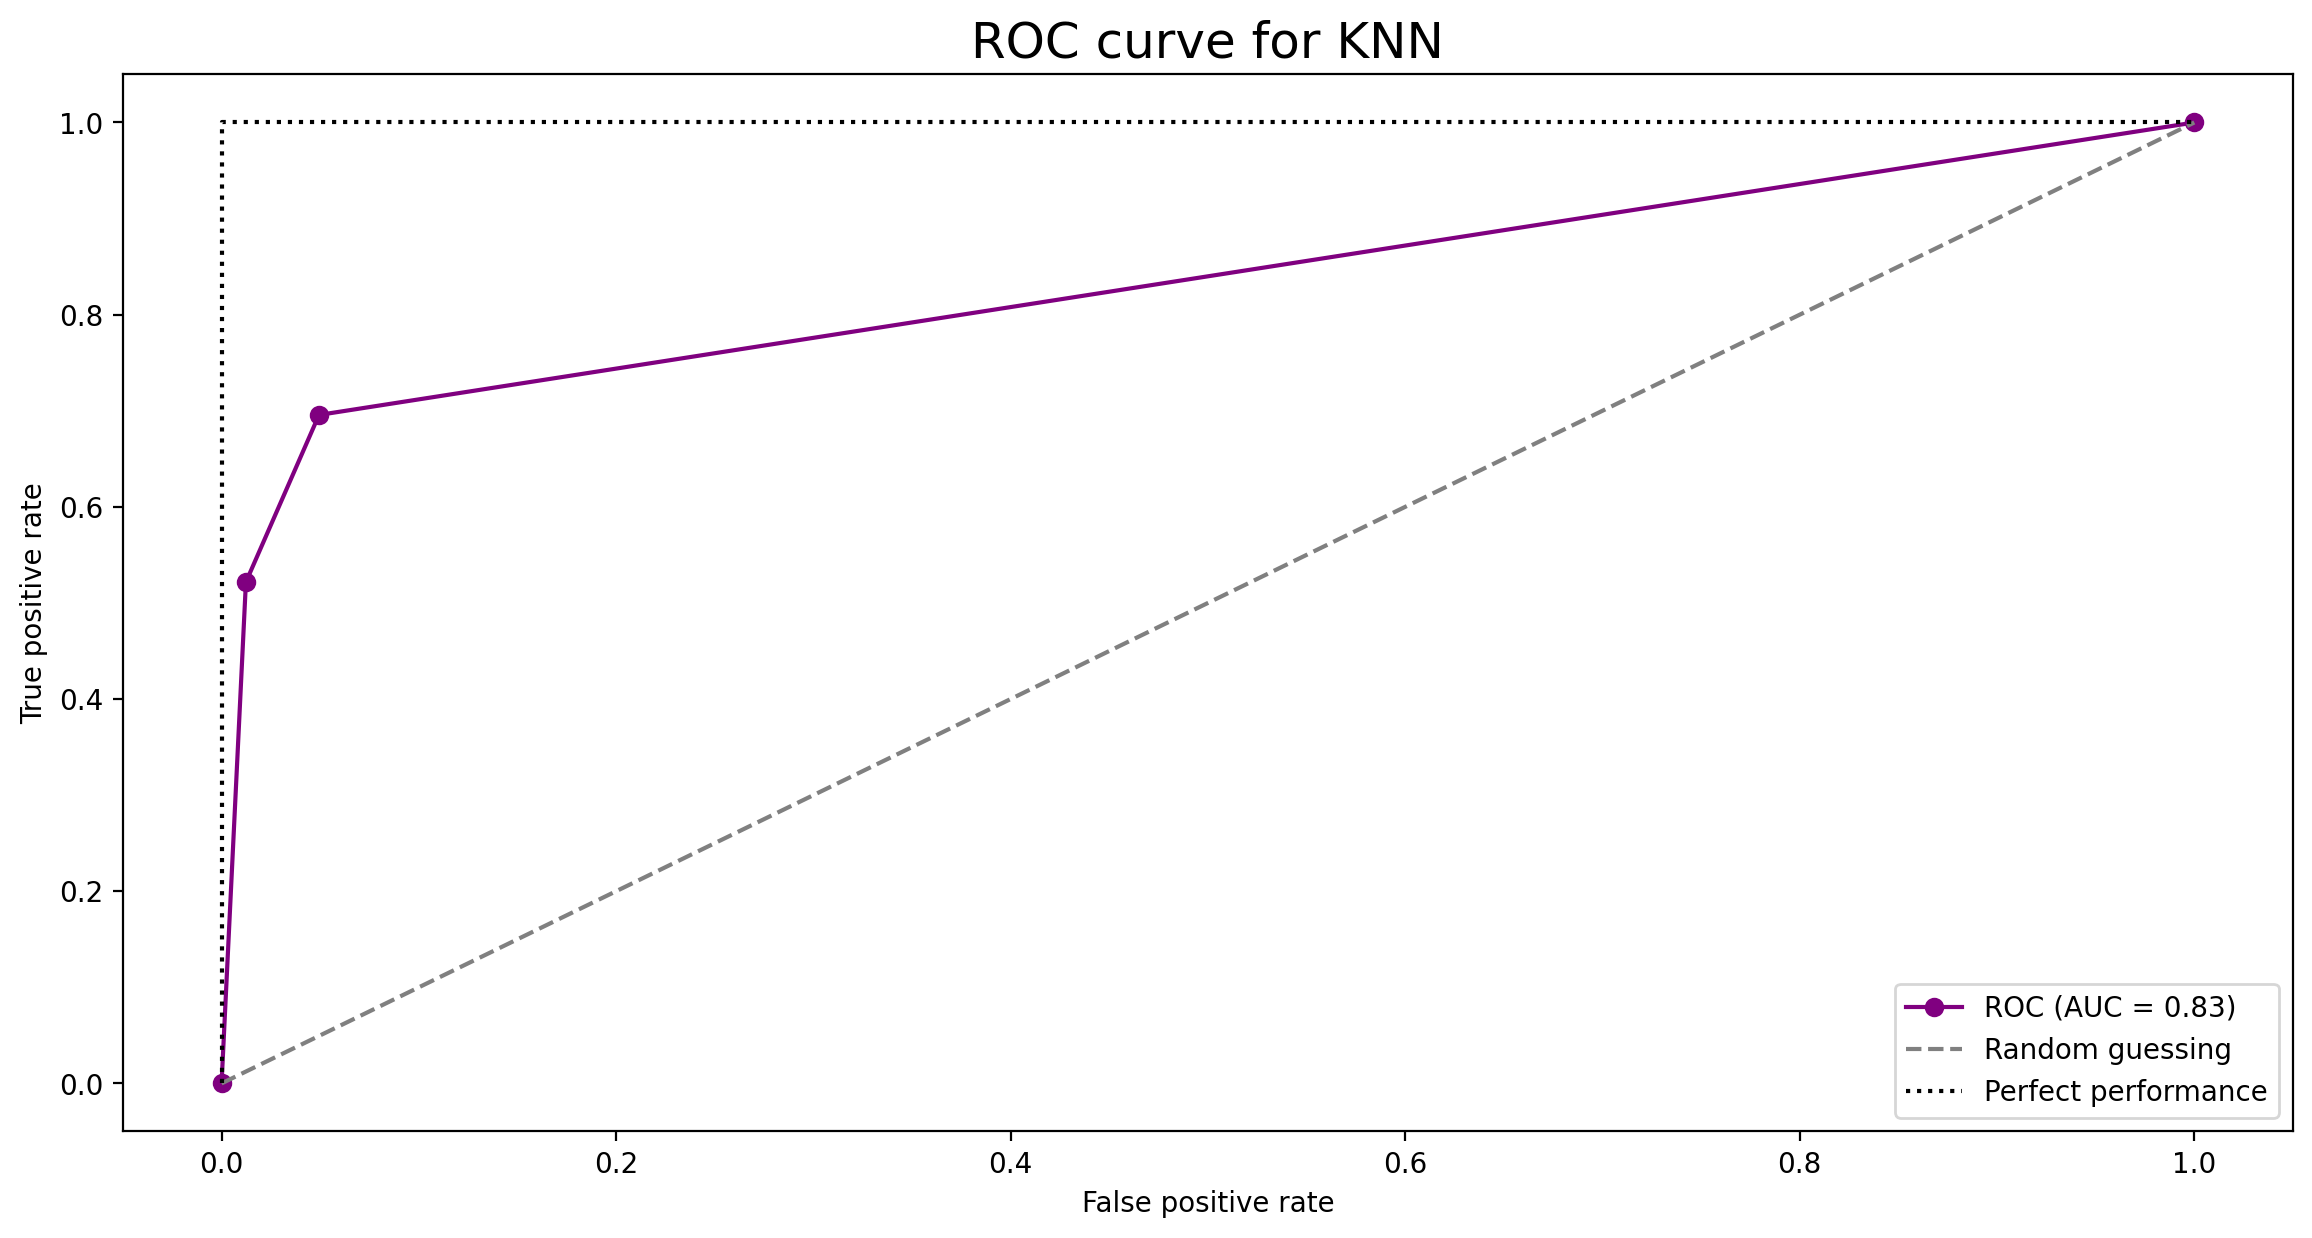

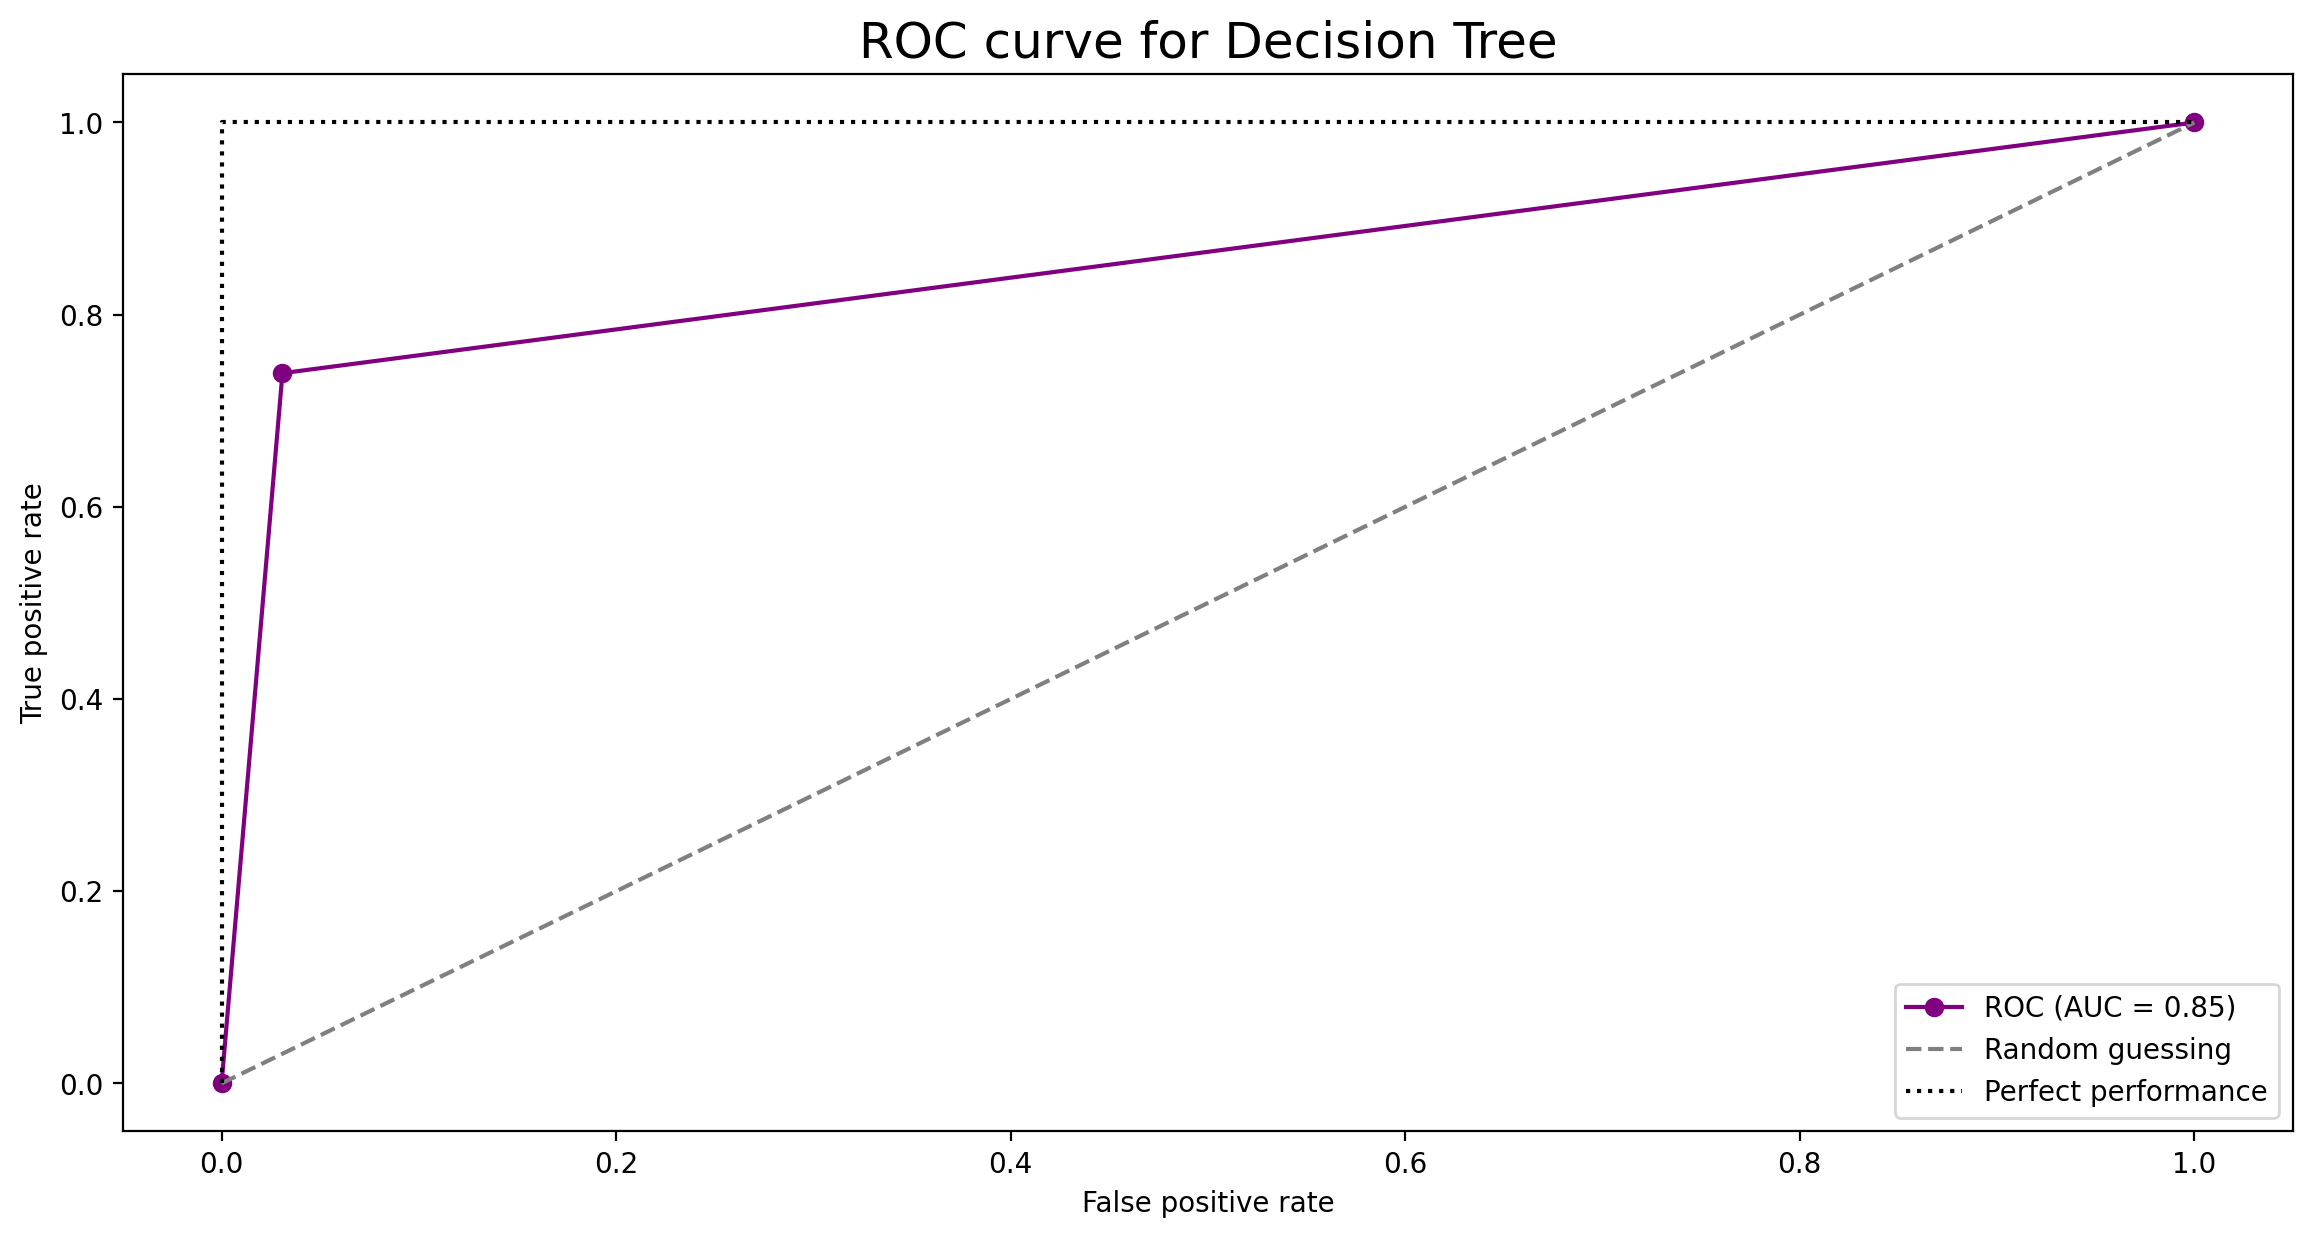

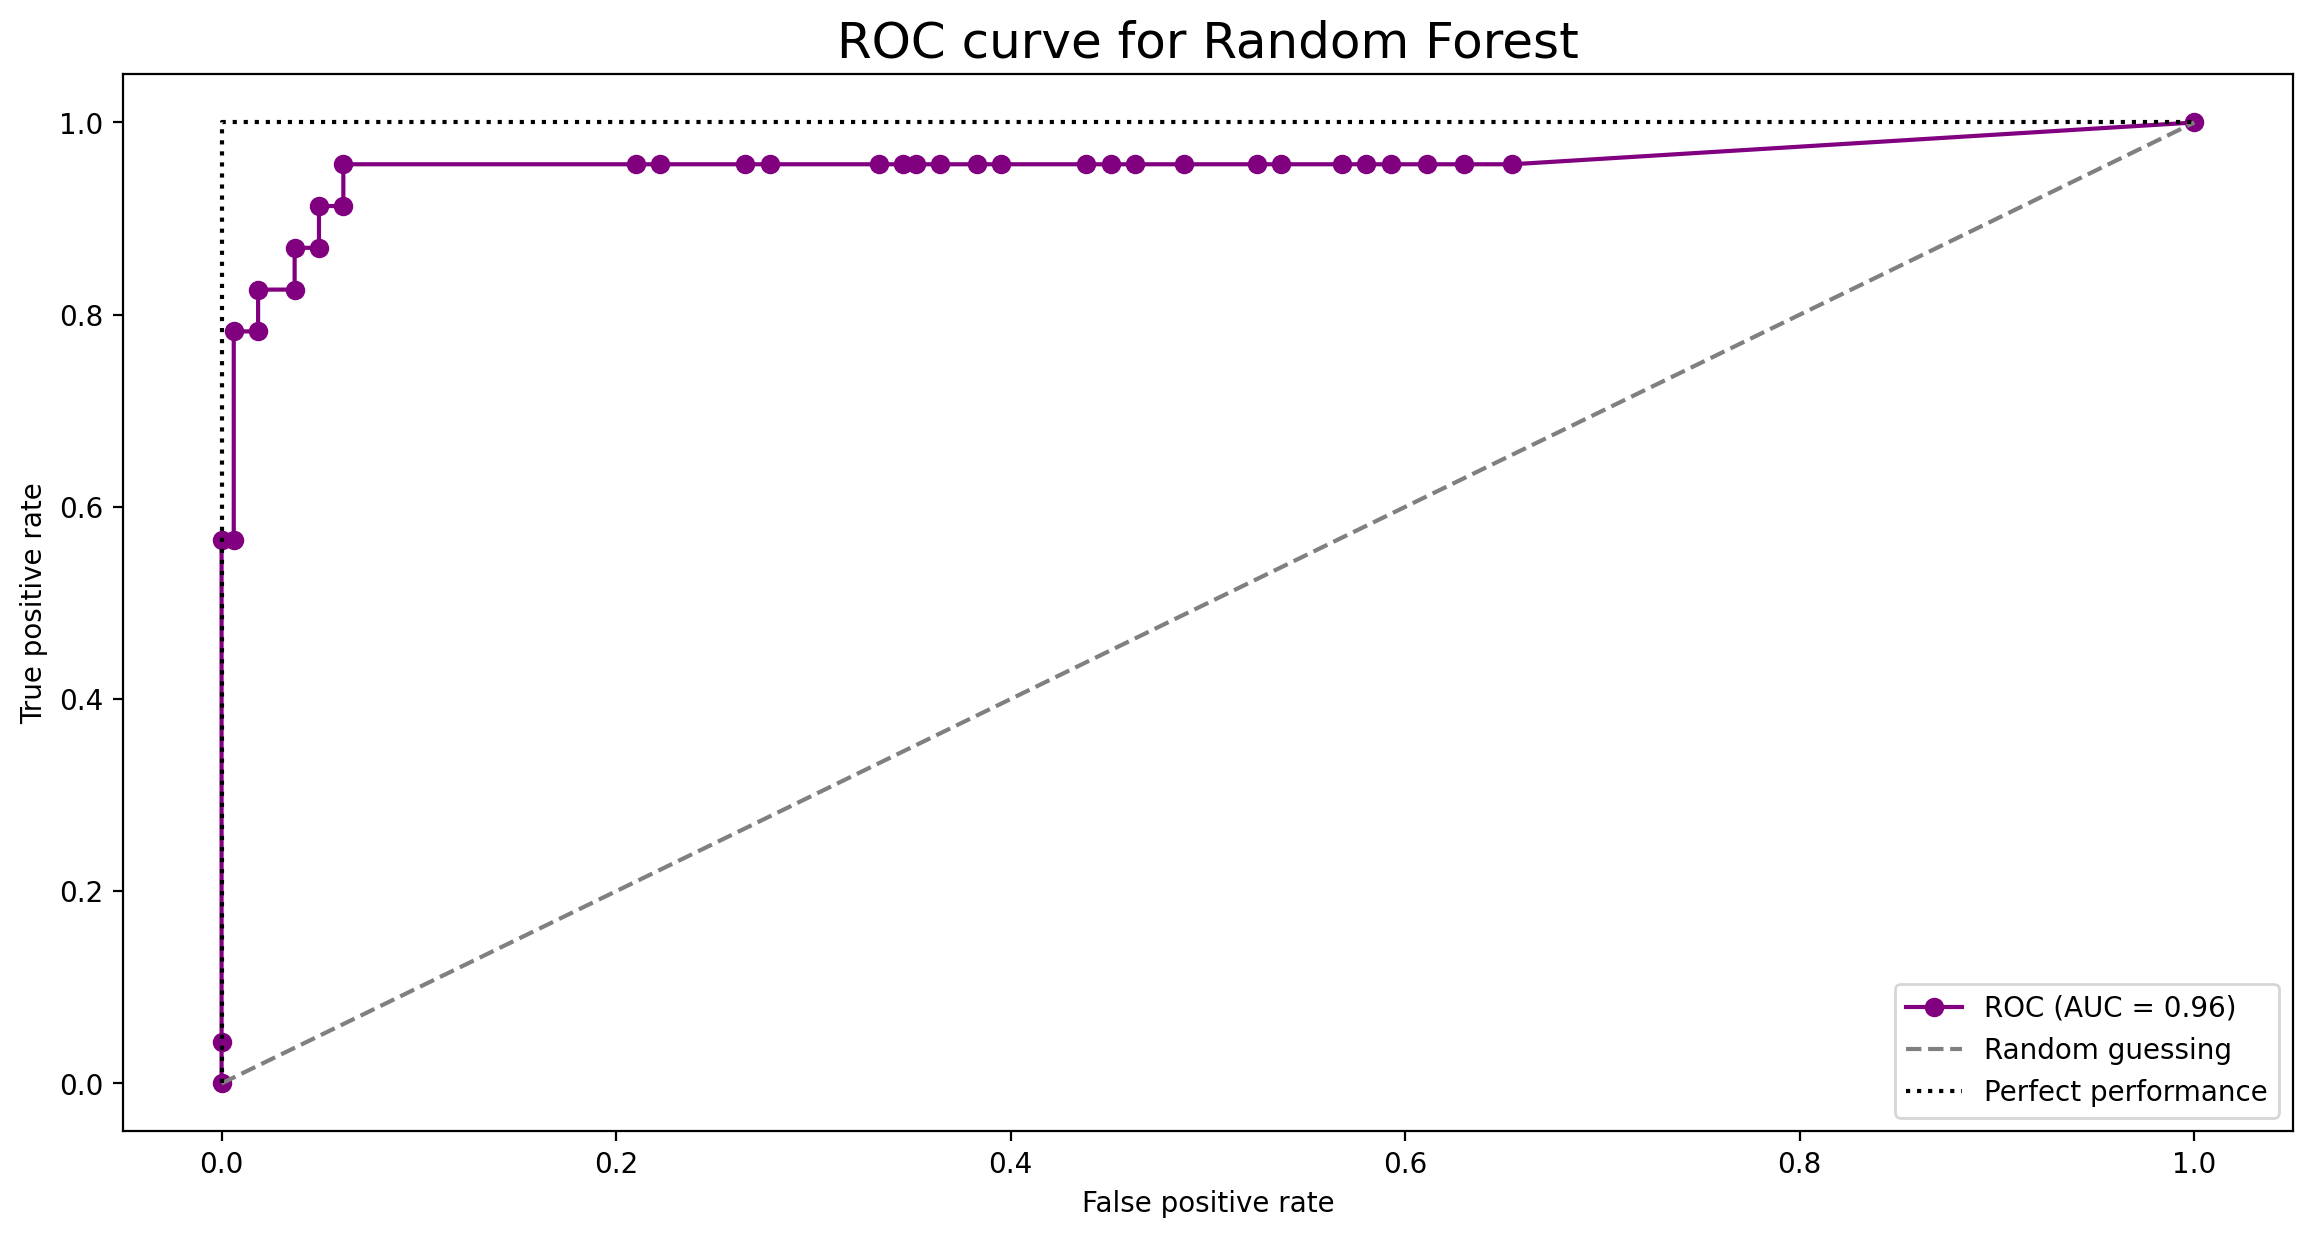

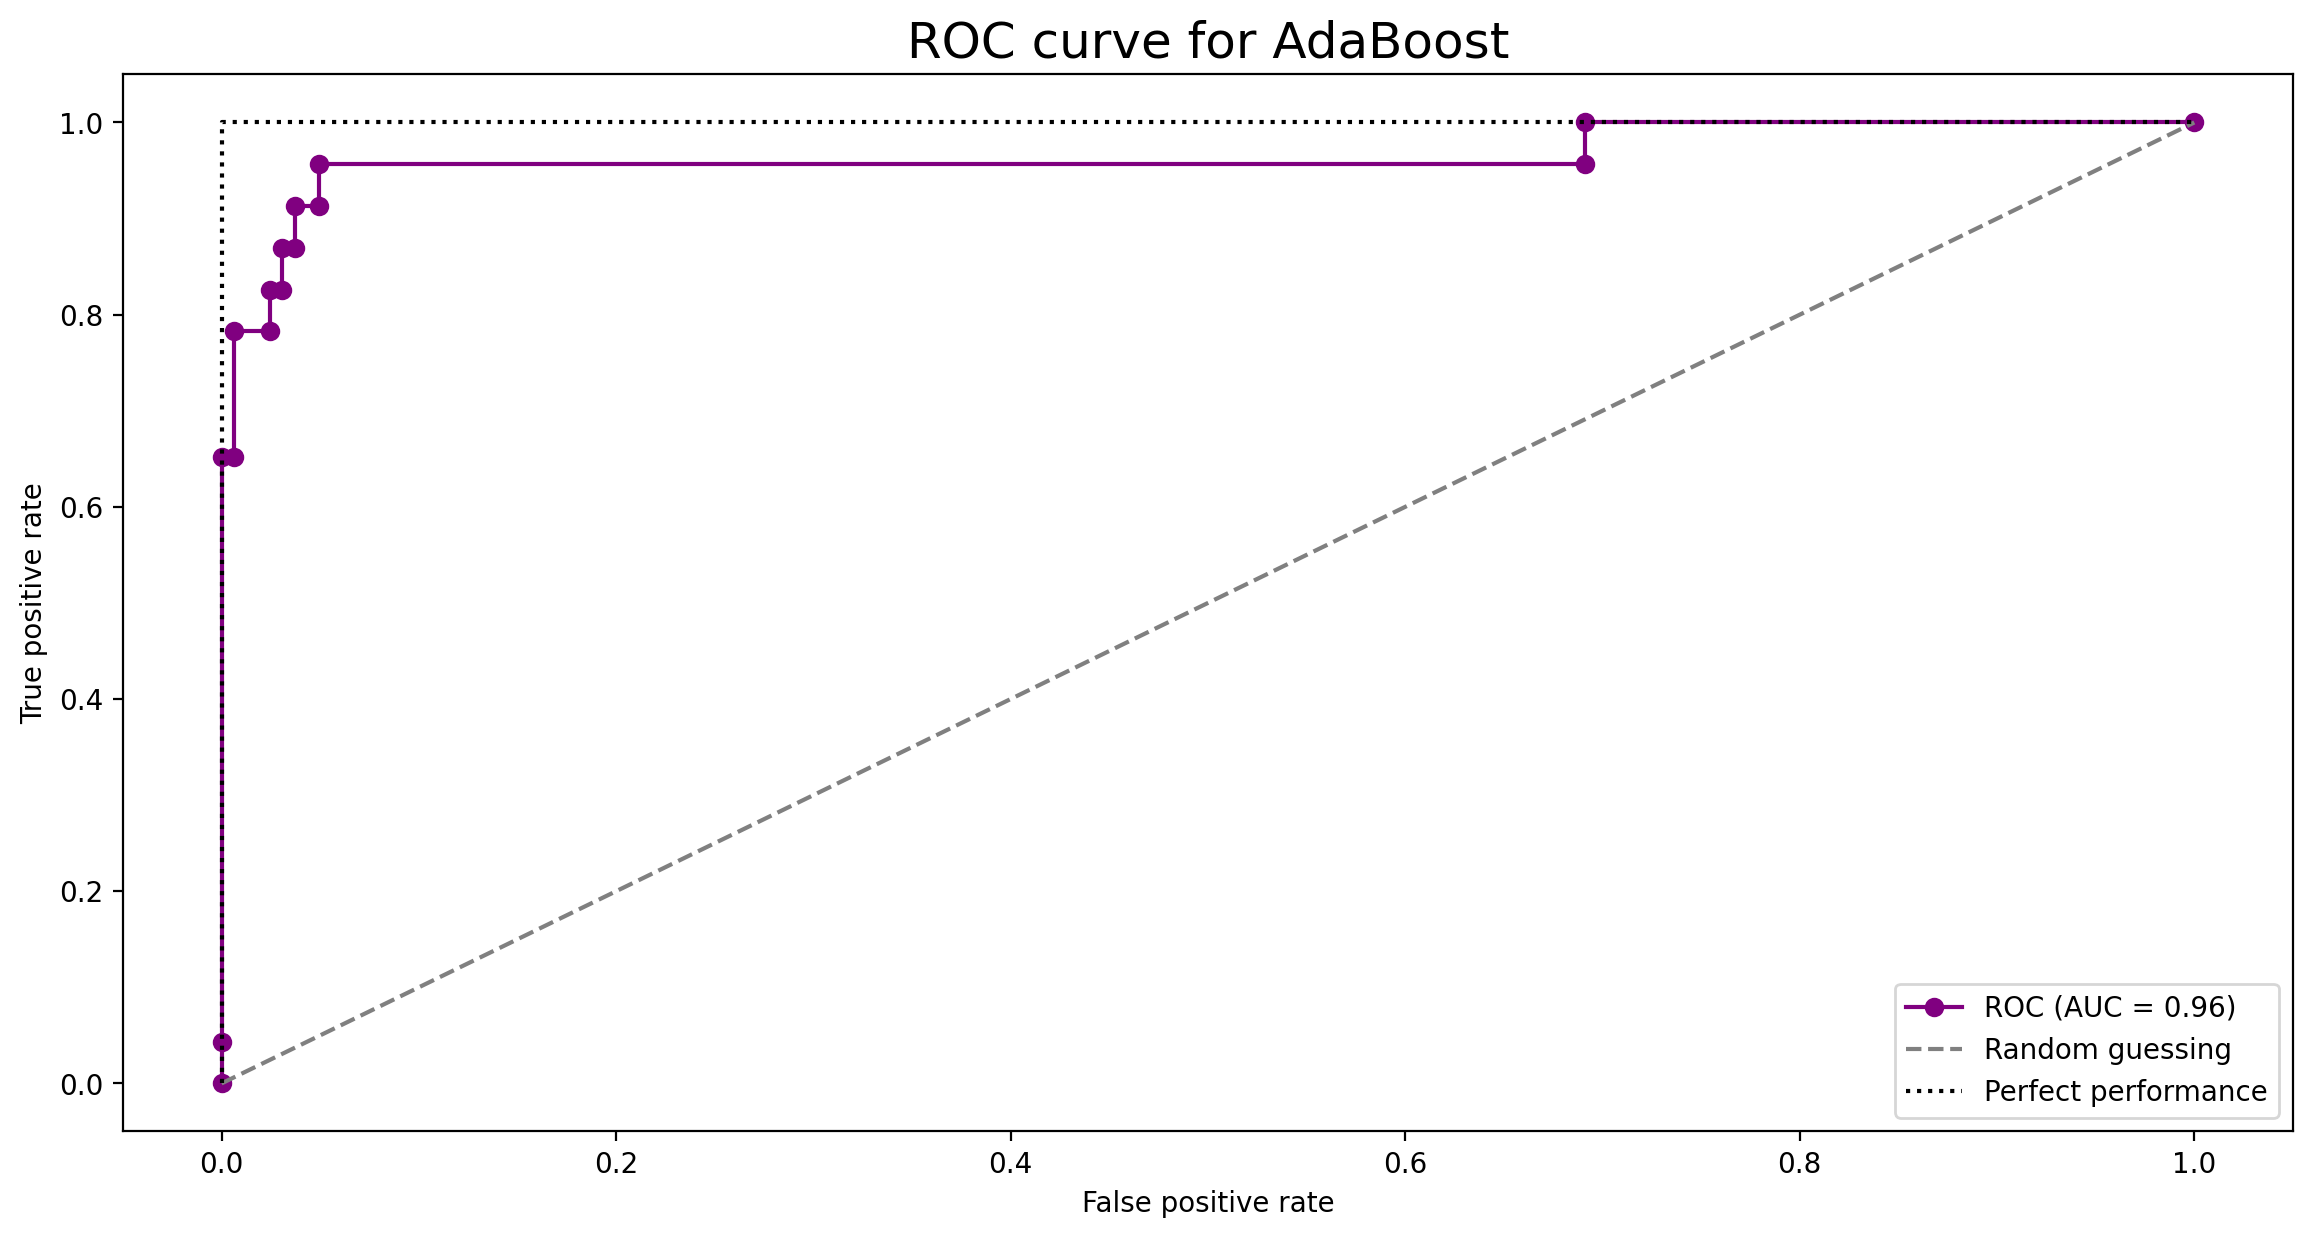

In [35]:
for clf, name in zip(classifiers, names):
    probas = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    fig = plt.figure(dpi=200, figsize=(14,7))
    plt.plot(fpr, tpr, color="purple", marker="o", label="ROC (AUC = %.2f)" % (roc_auc))
    plt.plot([0, 1], [0,1], linestyle="--", color="gray", label="Random guessing")
    plt.plot([0,0,1], [0,1,1], linestyle=":", color="black", label="Perfect performance")
    plt.legend(loc="best")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve for {}".format(name), fontsize=18)
    plt.savefig('saved_figs/'+name+'_ROC.svg', format='svg', dpi=fig.dpi)

Test accuracy for Logistic Regression: 0.95

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       162
           1       0.77      0.87      0.82        23

    accuracy                           0.95       185
   macro avg       0.88      0.92      0.89       185
weighted avg       0.95      0.95      0.95       185



<Figure size 720x720 with 0 Axes>

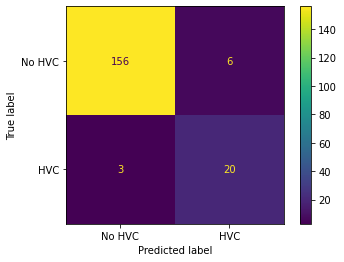

Test accuracy for SVC: 0.97

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       162
           1       0.88      0.91      0.89        23

    accuracy                           0.97       185
   macro avg       0.93      0.95      0.94       185
weighted avg       0.97      0.97      0.97       185



<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

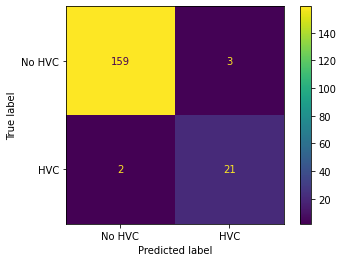

Test accuracy for KNN: 0.92

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       162
           1       0.74      0.61      0.67        23

    accuracy                           0.92       185
   macro avg       0.84      0.79      0.81       185
weighted avg       0.92      0.92      0.92       185



<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

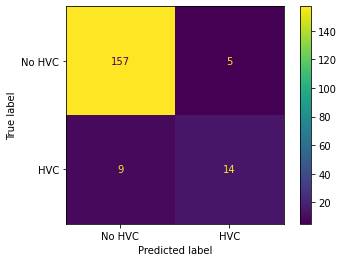

Test accuracy for Decision Tree: 0.94

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       162
           1       0.77      0.74      0.76        23

    accuracy                           0.94       185
   macro avg       0.87      0.85      0.86       185
weighted avg       0.94      0.94      0.94       185



<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

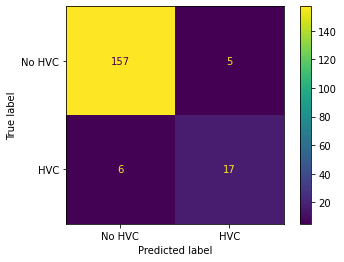

Test accuracy for Random Forest: 0.96

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       162
           1       0.90      0.78      0.84        23

    accuracy                           0.96       185
   macro avg       0.93      0.89      0.91       185
weighted avg       0.96      0.96      0.96       185



<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

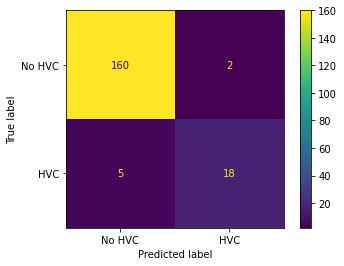

Test accuracy for AdaBoost: 0.96

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       162
           1       0.86      0.78      0.82        23

    accuracy                           0.96       185
   macro avg       0.91      0.88      0.90       185
weighted avg       0.96      0.96      0.96       185



<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

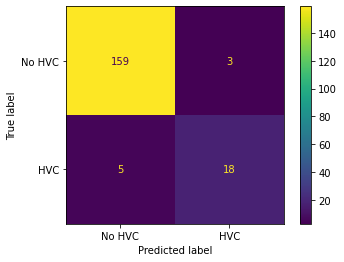

<Figure size 432x288 with 0 Axes>

In [36]:
for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(10,10))
    plot_confusion_matrix(clf, X_test, y_test, display_labels=categories)
    print('Test accuracy for {}:'.format(name), round(accuracy_score(y_test, clf.predict(X_test)), 2))
    print("")
    print(classification_report(y_test, clf.predict(X_test)))
    plt.show()
    plt.savefig('saved_figs/'+name+'_conf_matrix.svg', format='svg', dpi=fig.dpi)